In [18]:
import torch
from torch import nn
from typing import List
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelWithLMHead
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.metrics import classification_report
torch.__version__
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


from transformers import T5Tokenizer, T5ForConditionalGeneration

In [19]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")

# tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")
# model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-emotion")

In [20]:
def rank_nlp_dataset_final(dataset, tokenizer, model, prefix,classes=None):

    from cleanlab.rank import get_label_quality_scores
    #### Run the model 

    def get_emotion_probs(text):
        with torch.no_grad():
            enc = tokenizer(prefix+text, return_tensors="pt", padding=True)

            decoder_input_ids = torch.tensor([tokenizer.pad_token_id]).unsqueeze(0)
            
            logits = model(**enc, decoder_input_ids=decoder_input_ids)[0]
#             tokens = torch.argmax(logits, dim=2)
#             emotion = tokenizer.batch_decode(tokens)
        
        return F.softmax(logits,dim=2).squeeze(0)
    
    ## Get pred probs
    pred_probs=[]
    given = []
    encoded_classes = np.array([tokenizer.encode(cls)[:-1][0] for cls in classes])
    for idx in tqdm(range(len(dataset))):
        text,target_emo = dataset[idx]
        if classes is not None:
            probs = get_emotion_probs(text)[0][encoded_classes]
            renorm = probs/sum(probs)
            pred_probs.append(renorm)

            given.append(classes.index(target_emo))
        else:  
            pred_probs.append(get_emotion_probs(text)[0])
            given.append(tokenizer.encode(target_emo)[:-1])

        
    ## Prep for cleanlab
    pred_probs = np.stack(pred_probs)
    given = np.array(given)
    
    ranked_label_issues = get_label_quality_scores(given, pred_probs)
    return ranked_label_issues

In [21]:
from datasets import load_dataset
dataset = load_dataset("sst2")
# dataset = load_dataset("amazon_reviews_multi", "en")

  0%|          | 0/3 [00:00<?, ?it/s]

In [22]:
dataset['validation'][3]

{'idx': 3,
 'sentence': "the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . ",
 'label': 1}

In [23]:
smaller_dataset ={}
for i in tqdm(range(len(dataset['validation']))):
    sentence, label = dataset['validation'][i]["sentence"], dataset['validation'][i]["label"]
    new_label = "positive" if label==1 else "negative"
    smaller_dataset[i] = sentence, new_label

100%|██████████| 872/872 [00:00<00:00, 8240.36it/s]


In [24]:
rank3 = rank_nlp_dataset_final(smaller_dataset,tokenizer,model, "sst2 sentence: ", classes=["positive", "negative"] )

100%|██████████| 872/872 [00:35<00:00, 24.44it/s]


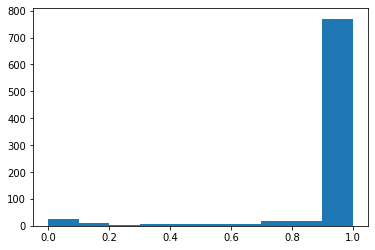

In [25]:
plt.hist(rank3)
plt.show()

In [26]:
np.argsort(rank3)

array([519,  95, 183,  92, 646, 791, 282, 271, 399, 764, 312, 579, 604,
       171, 707, 501,  46, 667, 115, 112, 464, 862, 411, 699, 449, 736,
       801, 487,  85,  21, 760,  93, 645, 827, 832, 695, 689, 685, 673,
       273, 358,  96, 477, 656, 345, 230, 665, 172, 846, 135, 561,  82,
       292, 324, 382,  87, 782, 274, 700, 158, 365, 595, 812, 102,  64,
       750, 118, 698, 377, 735, 823, 716, 448, 481,  22, 478, 684, 749,
       559, 166, 213, 785, 253, 819, 299, 741, 548, 495, 582, 563, 266,
       580, 757,  45,  78, 612, 124, 143, 279, 416, 527, 433, 356, 626,
       446, 405, 494, 338, 731, 121, 267,  61, 249, 869, 813, 401,  44,
       643, 454, 255, 161, 710, 856, 163, 211, 517, 659, 456, 634, 672,
        25, 829, 375, 724,  88, 388, 670, 256, 447,  62, 719, 702,  58,
        37, 189, 765, 753, 284, 218, 192, 771, 589, 434, 515, 617, 521,
       845, 126, 395, 260, 205, 139, 692, 704, 332, 441,   7, 385, 575,
       601, 472, 217, 489, 384, 571, 208, 852, 178, 276,  73, 83

In [27]:
np.argsort(rank3)

array([519,  95, 183,  92, 646, 791, 282, 271, 399, 764, 312, 579, 604,
       171, 707, 501,  46, 667, 115, 112, 464, 862, 411, 699, 449, 736,
       801, 487,  85,  21, 760,  93, 645, 827, 832, 695, 689, 685, 673,
       273, 358,  96, 477, 656, 345, 230, 665, 172, 846, 135, 561,  82,
       292, 324, 382,  87, 782, 274, 700, 158, 365, 595, 812, 102,  64,
       750, 118, 698, 377, 735, 823, 716, 448, 481,  22, 478, 684, 749,
       559, 166, 213, 785, 253, 819, 299, 741, 548, 495, 582, 563, 266,
       580, 757,  45,  78, 612, 124, 143, 279, 416, 527, 433, 356, 626,
       446, 405, 494, 338, 731, 121, 267,  61, 249, 869, 813, 401,  44,
       643, 454, 255, 161, 710, 856, 163, 211, 517, 659, 456, 634, 672,
        25, 829, 375, 724,  88, 388, 670, 256, 447,  62, 719, 702,  58,
        37, 189, 765, 753, 284, 218, 192, 771, 589, 434, 515, 617, 521,
       845, 126, 395, 260, 205, 139, 692, 704, 332, 441,   7, 385, 575,
       601, 472, 217, 489, 384, 571, 208, 852, 178, 276,  73, 83

In [28]:
np.argsort(rank3)
smaller_dataset[791]

("it 's somewhat clumsy and too lethargically paced -- but its story about a mysterious creature with psychic abilities offers a solid build-up , a terrific climax , and some nice chills along the way . ",
 'negative')

In [29]:
for num in np.argsort(rank3):
    print(smaller_dataset[num])

("moretti 's compelling anatomy of grief and the difficult process of adapting to loss . ", 'negative')
('this riveting world war ii moral suspense story deals with the shadow side of american culture : racial prejudice in its ugly and diverse forms . ', 'negative')
("the lower your expectations , the more you 'll enjoy it . ", 'negative')
("you wo n't like roger , but you will quickly recognize him . ", 'negative')
("the longer the movie goes , the worse it gets , but it 's actually pretty good in the first few minutes . ", 'negative')
("it 's somewhat clumsy and too lethargically paced -- but its story about a mysterious creature with psychic abilities offers a solid build-up , a terrific climax , and some nice chills along the way . ", 'negative')
("while there 's something intrinsically funny about sir anthony hopkins saying ` get in the car , bitch , ' this jerry bruckheimer production has little else to offer ", 'positive')
('as unseemly as its title suggests . ', 'positive')
("i

In [30]:
dataset_indicies = np.where(rank3>0.99)[0]

emotions = np.array(["positive", "negative"])

from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
def lift_at_k(y_true: np.array, y_score: np.array, k: int = 100) -> float:
    """Compute Lift at K evaluation metric"""

    # sort scores
    sort_indices = np.argsort(y_score)

    # compute lift for the top k values
    lift_at_k = y_true[sort_indices][-k:].mean() / y_true.mean()

    return lift_at_k

def compute_metrics(scores: np.array, true_error: np.array, metrics_metadata: dict={}, plot=True) -> dict:
    """
    Uses passed in `scores` of length (N,) and `true_error` mask of length (N,) to calculate metrics for the data.
    
    Parameters
    ----------
    scores : np.ndarray
      Scores per example with values [0,1]. Smaller values indicating examples that are more likeley to have error. 
      Can come directly from calclation like `scores = get_label_quality_scores()`.
    
    true_error : np.ndarray
      Binary mask indicating which examples have error with 1 = error and 0 = no error.
      
    metrics_metadata : dict
      Additional information to append to the calculated metrics dict.
      
    Returns
    -------
    metrics : dict
      A dictionary of computed metrics given `scores` and `true_error`. 
    """
    # compute precision-recall curve using quality scores
    precision, recall, thresholds = precision_recall_curve(true_error, 1 - scores)
    
    # compute prc auc scores
    auprc = auc(recall, precision)
    
    # compute accuracy of detecting errors
    auroc = roc_auc_score(true_error, 1 - scores)

    # lift at K where K = number of errors
    lift_at_num_errors = lift_at_k(true_error, 1 - scores, k=true_error.sum())

    # lift at k=100
    lift_at_100 = lift_at_k(true_error, 1 - scores, k=100)
    
    # feel free to add your own metrics
    metrics = {
        "dataset_num_samples": len(scores),
        "dataset_num_errors": true_error.sum(),
        "auroc": auroc,
        "auprc": auprc,
        "precision": precision,
        "recall": recall,
        "thresholds": thresholds,
        "lift_at_num_errors": lift_at_num_errors,
        "lift_at_100": lift_at_100,
    }
    
    if len(metrics_metadata) > 0:
        metrics = {**metrics_metadata, **metrics}
        
    if plot:
        fpr, tpr, _ = roc_curve(true_error, 1-scores) 
        fig1,(ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
        ax1.plot(fpr, tpr)
        ax1.set_xlabel("False Positive Rate")
        ax1.set_ylabel("True Positive Rate")
        ax1.set_title(f"AUROC={auroc}")
        ax2.plot(recall, precision) 
        ax2.set_xlabel("Recall")
        ax2.set_title(f"AUPRC={auprc}")
        ax2.set_ylabel("Precision")
        plt.show()
        
    return metrics

In [31]:
emotions = np.array(emotions)

100%|██████████| 659/659 [00:26<00:00, 24.42it/s]


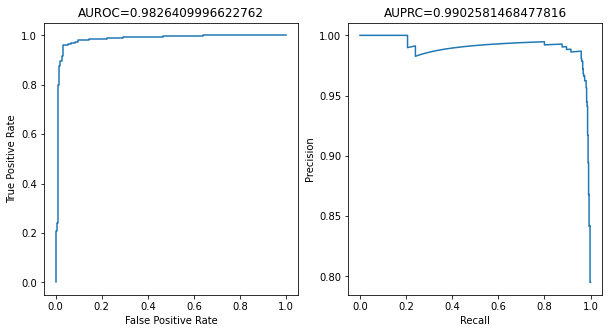

{'dataset_num_samples': 659,
 'dataset_num_errors': 470,
 'auroc': 0.9826409996622762,
 'auprc': 0.9902581468477816,
 'precision': array([0.79526227, 0.79491525, 0.79626486, 0.79761905, 0.79897785,
        0.8003413 , 0.8017094 , 0.80308219, 0.80445969, 0.80584192,
        0.80722892, 0.80862069, 0.81001727, 0.81141869, 0.81282496,
        0.81423611, 0.81565217, 0.81707317, 0.81849913, 0.81993007,
        0.82136602, 0.82280702, 0.82425308, 0.82570423, 0.82716049,
        0.82862191, 0.8300885 , 0.83156028, 0.8330373 , 0.83451957,
        0.83600713, 0.8375    , 0.83899821, 0.84050179, 0.84201077,
        0.84172662, 0.84144144, 0.84296029, 0.84448463, 0.84601449,
        0.84754991, 0.84909091, 0.85063752, 0.85218978, 0.85374771,
        0.85531136, 0.85688073, 0.85845588, 0.86003683, 0.86162362,
        0.86321627, 0.86481481, 0.86641929, 0.86802974, 0.86778399,
        0.86940299, 0.87102804, 0.87265918, 0.87429644, 0.87593985,
        0.87758945, 0.87924528, 0.88090737, 0.88257576

In [33]:
np.random.seed(seed=4)

has_error = []
new_dataset = {}
for idx in range(len(dataset_indicies)):
    source,target = smaller_dataset[idx]
    if np.random.random() >0.3:
        target = emotions[emotions!=target][0]
        has_error.append(1)
    else:
        has_error.append(0)
    new_dataset[idx] = source, target
    
    
rank_with_error = rank_nlp_dataset_final(new_dataset,tokenizer,model, "sst2 sentence: ", classes=["positive", "negative"] )

compute_metrics(rank_with_error,np.array(has_error))

In [34]:
len(dataset_indicies)

659